In [ ]:
### LSTM TO PRODICT PITCHCES
# _imports__
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras import Model


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow.keras as kb

import pandas as pd

In [ ]:
## DATA IMPORT
# a ton of data here
!unzip -qq BaseBall-Data_2.zip

In [ ]:
## SCONDARY IMPORTS
import pandas as pd

atbats = pd.read_csv("BaseBall-Data/atbats.csv")
#games = pd.read_csv("BaseBall-Data/games.csv")
pitches = pd.read_csv("BaseBall-Data/pitches.csv")

In [ ]:
## DATA CLEANING
# slim down pitches to only 1 year-ish
pitchesSlim = pitches.head(pitches.shape[0])
#games = games.head(games.shape[0])
atbatsSlim = atbats.head(atbats.shape[0])

#delete rows
# pitches -- complete --
pitchesSlim = pitchesSlim.drop(columns = ['px','pz','start_speed','end_speed','spin_rate','spin_dir','break_angle','break_length','break_y'])
pitchesSlim = pitchesSlim.drop(columns = ['ax','ay','az','sz_bot','sz_top','type_confidence','vx0','vy0','vz0', 'x'])
pitchesSlim = pitchesSlim.drop(columns = ['x0','y','y0','z0','pfx_x','pfx_z','nasty','zone','code'])

# add spacers to the at bat
#fullAtbats = atbats.loc[atbats.index.repeat()].reset_index(drop=True)
fullAtbats = atbatsSlim.merge(pitchesSlim, on = 'ab_id')
fullAtbats = fullAtbats.drop(columns=['event', 'stand', 'p_throws', 'type'])


In [ ]:
## find specific players
names = pd.read_csv("BaseBall-Data/player_names.csv")

my_guy = names[names['last_name'] == 'Darvish']
my_guy

,id,first_name,last_name
815,506433,Yu,Darvish


In [ ]:
# Define acceptable pitch types
valid_pitch_dict = {
    'FF': 'Four-Seam Fastball', 'FT': 'Two-Seam Fastball',
    'CH': 'Change-up', 'CU': 'Curveball',
    'FC': 'Cutter', 'EP': 'Eephus',
    'FO': 'Forkball', 'KC': 'Knuckle Curve',
    'KN': 'Knuckleball', 'SC': 'Screwball',
    'SI': 'Sinker', 'SL': 'Slider',
    'FS': 'Splitter',
}

In [ ]:
## retrying some data cleaning
word_counts = fullAtbats['pitcher_id'].value_counts()

# print the counts
#print("Most frequent name is", word_counts.index[250])

## new df
specificBats = fullAtbats[fullAtbats['pitcher_id'] == 506433]
#specificBats.info()

In [ ]:
#fullAtbats = fullAtbats.drop(columns = ['event', 'type','p_throws','stand'])
#fullAtbats = fullAtbats.head(15000)
fullAtbats = specificBats
fullAtbats = fullAtbats[
    fullAtbats['pitch_type'].str.contains(
        '|'.join(list(valid_pitch_dict.keys())), na=False)
    ]
fullAtbats.info()
fullAtbats.to_csv('cleanFullAtbatsByPitcher.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 5355 entries, 916577 to 2346358
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       5355 non-null   int64  
 1   batter_id   5355 non-null   int64  
 2   g_id        5355 non-null   int64  
 3   inning      5355 non-null   int64  
 4   o           5355 non-null   int64  
 5   p_score     5355 non-null   int64  
 6   pitcher_id  5355 non-null   int64  
 7   top         5355 non-null   bool   
 8   pitch_type  5355 non-null   object 
 9   event_num   5355 non-null   int64  
 10  b_score     5355 non-null   float64
 11  b_count     5355 non-null   float64
 12  s_count     5355 non-null   float64
 13  outs        5355 non-null   float64
 14  pitch_num   5355 non-null   float64
 15  on_1b       5355 non-null   float64
 16  on_2b       5355 non-null   float64
 17  on_3b       5355 non-null   float64
dtypes: bool(1), float64(8), int64(8), object(1)
memory usage: 758.3+ 

In [ ]:
top_pitch = fullAtbats['pitch_type'].value_counts().head(5)
for i in range(5):
  top_pitch_name = valid_pitch_dict[top_pitch.index[i]]
  top_pitch_freq = int((top_pitch.values[i] / len(fullAtbats)) * 100)
  print(f'Yu Darvish throws {top_pitch_name} {top_pitch_freq}% of the time')

Yu Darvish throws Four-Seam Fastball 36% of the time
Yu Darvish throws Slider 23% of the time
Yu Darvish throws Two-Seam Fastball 18% of the time
Yu Darvish throws Cutter 12% of the time
Yu Darvish throws Curveball 6% of the time


In [ ]:
## define how to make the sequences
class Sequencer:
  def __init__(self,
                 data: pd.core.frame.DataFrame,
                 max_length: int,
                 n_features: int,
                 n_pitch_types: int) -> None:
        self.data = data
        self.max_length = max_length
        self.n_features = n_features
        self.n_pitch_types = n_pitch_types
  def _make_mappings(self, group):
        data_arr = group.values
        dict_keys = [i for i in range(1, len(group)+ 1)] #1-indexing the feature vectors lets us reserve 0 for padding
        features = data_arr[:,1 : -self.n_pitch_types]
        labels = data_arr[:, -self.n_pitch_types:]
        index_to_pitch = dict(zip(dict_keys, features))
        index_to_pitch[0] = np.zeros(features.shape[1], dtype='int64')
        index_to_label = dict(zip(dict_keys, labels))
        return index_to_pitch, index_to_label
  def _ascending_subsequences(self, increasing_list: list):
        subsequences = []
        n = len(increasing_list)
        for i in range(n):
            for j in range(i+1, n+1):
                subsequences.append(increasing_list[i:j])
        return subsequences
  def _build_sequences(self, subsequences):
        length = self.max_length
        processed_sublists = []
        for sublist in subsequences:
            sublist_length = len(sublist)
            if sublist_length < length: # If too short
                sublist.extend([0] * (length - sublist_length))
                processed_sublists.append(sublist)
            else:
                num_sublists = (sublist_length + length - 1) // length
                pad_length = num_sublists * length - sublist_length
                sublist = np.pad(sublist, (0, pad_length), mode='constant', constant_values=0)
                processed_sublists.extend(np.split(sublist, num_sublists))
        return np.array(processed_sublists)
  def _populate_vectors(self, group):
        group = group.sort_values('pitch_num', ascending=True)
        index_to_pitch, index_to_label = self._make_mappings(group)
        subsequences = self._ascending_subsequences(list(index_to_label.keys()))
        index_to_label[0] = np.zeros(self.n_pitch_types, dtype='int64') # add this now to prevent messing up the key length
        processed_sublists = self._build_sequences(subsequences)
        all_features = np.array([[index_to_pitch[i] for i in sublist] for sublist in processed_sublists])
        all_labels = np.array(
            [index_to_label[max(sublist)] for sublist in processed_sublists]
        )
        return all_features, all_labels
  def make_sequences(self):
        data = self.data.astype(np.float64)
        test_split_ratio = 0.8
        val_split_ratio = 0.9
        train_val_size = int(len(data) * test_split_ratio)
        train_val_data, test_data = data[:train_val_size], data[train_val_size:]
        train_size = int(len(train_val_data) * val_split_ratio)
        train_data, val_data = train_val_data[:train_size], train_val_data[train_size:]
        train_sequences = train_data.groupby('ab_id').apply(self._populate_vectors)
        X_train = np.concatenate([result[0] for result in train_sequences])
        y_train = np.concatenate([result[1] for result in train_sequences])
        val_sequences = val_data.groupby('ab_id').apply(self._populate_vectors)
        X_val = np.concatenate([result[0] for result in val_sequences])
        y_val = np.concatenate([result[1] for result in val_sequences])
        test_sequences = test_data.groupby('ab_id').apply(self._populate_vectors)
        X_test = np.concatenate([result[0] for result in test_sequences])
        y_test = np.concatenate([result[1] for result in test_sequences])
        return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
repertoire_abb = fullAtbats['pitch_type'].unique()

repertoire_size = len(repertoire_abb)
n_features = fullAtbats.shape[1] - repertoire_size
repertoire_abb

array(['FF', 'FT', 'SL', 'FC', 'CU', 'FS', 'CH', 'EP'], dtype=object)

In [ ]:
# one hot encode categorical values
df_encoded = pd.get_dummies(fullAtbats, columns=['pitch_type'])
build = fullAtbats['pitch_type']
setup = df_encoded.drop(columns=['ab_id','batter_id','g_id','inning','o','p_score',
                                 'pitcher_id','top','event_num','b_score','b_count','s_count',
                                 'outs','pitch_num','on_1b','on_2b','on_3b'])

coding_to_pitches = pd.concat([setup, build], ignore_index=True, sort=False)

In [ ]:

seq = Sequencer(data=df_encoded,
                max_length=6,
                n_features=n_features,
                n_pitch_types=repertoire_size
                )
X_train, X_val, X_test, y_train, y_val, y_test = seq.make_sequences()


In [ ]:
# MODEL STRUCTURE

# LSTM model
inputs = Input(shape = (X_train.shape[1], X_train.shape[2]))
x = LSTM(100, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(100)(x)
x = Dropout(0.2)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs = inputs, outputs = output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 6, 16)]           0         
                                                                 
 lstm_35 (LSTM)              (None, 6, 100)            46800     
                                                                 
 dropout_22 (Dropout)        (None, 6, 100)            0         
                                                                 
 lstm_36 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_65 (Dense)            (None, 8)                 808       
                                                                 
Total params: 128008 (500.03 KB)
Trainable params: 128008 

In [ ]:
# FIT MODEL
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))
history

Epoch 1/40
349/349 [==============================] - 10s 15ms/step - loss: 1.5730 - accuracy: 0.3578 - val_loss: 1.6149 - val_accuracy: 0.3239
Epoch 2/40
349/349 [==============================] - 6s 17ms/step - loss: 1.5608 - accuracy: 0.3679 - val_loss: 1.5972 - val_accuracy: 0.3291
Epoch 3/40
349/349 [==============================] - 7s 20ms/step - loss: 1.5568 - accuracy: 0.3685 - val_loss: 1.6101 - val_accuracy: 0.3247
Epoch 4/40
349/349 [==============================] - 5s 13ms/step - loss: 1.5557 - accuracy: 0.3693 - val_loss: 1.5965 - val_accuracy: 0.3247
Epoch 5/40
349/349 [==============================] - 5s 14ms/step - loss: 1.5531 - accuracy: 0.3716 - val_loss: 1.6012 - val_accuracy: 0.3247
Epoch 6/40
349/349 [==============================] - 7s 21ms/step - loss: 1.5523 - accuracy: 0.3699 - val_loss: 1.6015 - val_accuracy: 0.3247
Epoch 7/40
349/349 [==============================] - 6s 17ms/step - loss: 1.5529 - accuracy: 0.3728 - val_loss: 1.6071 - val_accuracy: 0.324

In [ ]:
#model.predict(X_test)
# get model's prediction (as a one hot vec)
prediction = model.predict(X_test) # predicted probs
for i in range(25):
  index = np.argmax(prediction[i]) # find highest prop
  print(repertoire_abb[index])
 # use one hots to grab actual characters
#result = coding_to_pitches[index]

100/100 [==============================] - 1s 10ms/step
CU
CU
CU
CU
CU
CU
EP
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU
CU


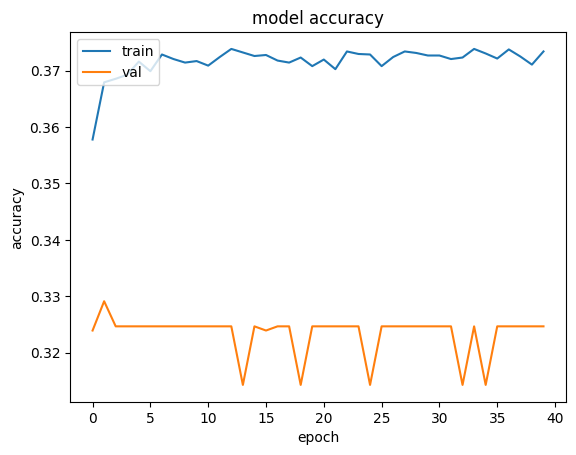

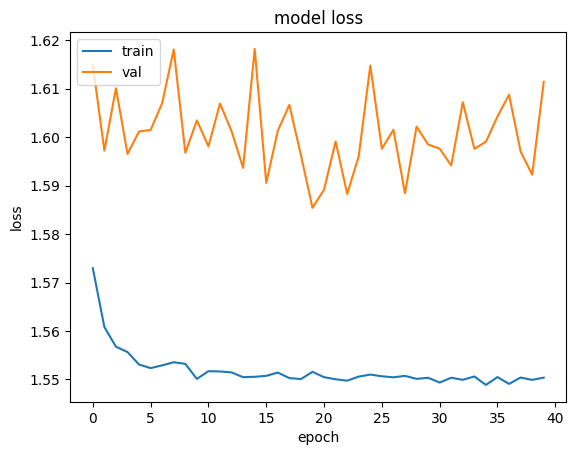

In [ ]:
## MEASURE OUTPUTS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## With another pitcher:
## DATA CLEANING
# slim down pitches to only 1 year-ish
pitchesSlim = pitches.head(pitches.shape[0])
#games = games.head(games.shape[0])
atbatsSlim = atbats.head(atbats.shape[0])

#delete rows
# pitches -- complete --
pitchesSlim = pitchesSlim.drop(columns = ['px','pz','start_speed','end_speed','spin_rate','spin_dir','break_angle','break_length','break_y'])
pitchesSlim = pitchesSlim.drop(columns = ['ax','ay','az','sz_bot','sz_top','type_confidence','vx0','vy0','vz0', 'x'])
pitchesSlim = pitchesSlim.drop(columns = ['x0','y','y0','z0','pfx_x','pfx_z','nasty','zone','code'])

# add spacers to the at bat
#fullAtbats = atbats.loc[atbats.index.repeat()].reset_index(drop=True)
fullAtbats = atbatsSlim.merge(pitchesSlim, on = 'ab_id')
fullAtbats = fullAtbats.drop(columns=['event', 'stand', 'p_throws', 'type'])


In [ ]:
## retrying some data cleaning
pitch_counts = fullAtbats['pitcher_id'].value_counts()

# print the counts
#print("Most frequent name is", word_counts.index[250])

## new df
specificBats = fullAtbats[fullAtbats['pitcher_id'] == pitch_counts.index[0]]
#specificBats.info()

In [ ]:

fullAtbats = specificBats
fullAtbats = fullAtbats[
    fullAtbats['pitch_type'].str.contains(
        '|'.join(list(valid_pitch_dict.keys())), na=False)
    ]
fullAtbats.info()
#fullAtbats.to_csv('cleanFullAtbatsByPitcher.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 13479 entries, 2407 to 2843325
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       13479 non-null  int64  
 1   batter_id   13479 non-null  int64  
 2   g_id        13479 non-null  int64  
 3   inning      13479 non-null  int64  
 4   o           13479 non-null  int64  
 5   p_score     13479 non-null  int64  
 6   pitcher_id  13479 non-null  int64  
 7   top         13479 non-null  bool   
 8   pitch_type  13479 non-null  object 
 9   event_num   13479 non-null  int64  
 10  b_score     13479 non-null  float64
 11  b_count     13479 non-null  float64
 12  s_count     13479 non-null  float64
 13  outs        13479 non-null  float64
 14  pitch_num   13479 non-null  float64
 15  on_1b       13479 non-null  float64
 16  on_2b       13479 non-null  float64
 17  on_3b       13479 non-null  float64
dtypes: bool(1), float64(8), int64(8), object(1)
memory usage: 1.9+ MB


In [ ]:
top_pitch = fullAtbats['pitch_type'].value_counts().head(3)
for i in range(3):
  top_pitch_name = valid_pitch_dict[top_pitch.index[i]]
  top_pitch_freq = int((top_pitch.values[i] / len(fullAtbats)) * 100)
  print(f'Second pitcher throws {top_pitch_name} {top_pitch_freq}% of the time')

Second pitcher throws Four-Seam Fastball 52% of the time
Second pitcher throws Slider 19% of the time
Second pitcher throws Change-up 13% of the time


In [ ]:
repertoire_abb = fullAtbats['pitch_type'].unique()

repertoire_size = len(repertoire_abb)
n_features = fullAtbats.shape[1] - repertoire_size
repertoire_abb

array(['FF', 'CH', 'SL', 'FC', 'CU', 'FT'], dtype=object)

In [ ]:
df_encoded = pd.get_dummies(fullAtbats, columns=['pitch_type'])
seq = Sequencer(data=df_encoded,
                max_length=6,
                n_features=n_features,
                n_pitch_types=repertoire_size
                )
X_train, X_val, X_test, y_train, y_val, y_test = seq.make_sequences()

In [ ]:
# MODEL STRUCTURE

# LSTM model
inputs = Input(shape = (X_train.shape[1], X_train.shape[2]))
x = LSTM(100, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(100)(x)
x = Dropout(0.2)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs = inputs, outputs = output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 6, 16)]           0         
                                                                 
 lstm_37 (LSTM)              (None, 6, 100)            46800     
                                                                 
 dropout_24 (Dropout)        (None, 6, 100)            0         
                                                                 
 lstm_38 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_25 (Dropout)        (None, 100)               0         
                                                                 
 dense_66 (Dense)            (None, 6)                 606       
                                                                 
Total params: 127806 (499.24 KB)
Trainable params: 127806 

In [ ]:
# FIT MODEL
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))
history

Epoch 1/40
894/894 [==============================] - 21s 19ms/step - loss: 1.3180 - accuracy: 0.5197 - val_loss: 1.5171 - val_accuracy: 0.4832
Epoch 2/40
894/894 [==============================] - 15s 16ms/step - loss: 1.3089 - accuracy: 0.5213 - val_loss: 1.5276 - val_accuracy: 0.4832
Epoch 3/40
894/894 [==============================] - 13s 15ms/step - loss: 1.3065 - accuracy: 0.5213 - val_loss: 1.5190 - val_accuracy: 0.4832
Epoch 4/40
894/894 [==============================] - 16s 17ms/step - loss: 1.3056 - accuracy: 0.5213 - val_loss: 1.4898 - val_accuracy: 0.4832
Epoch 5/40
894/894 [==============================] - 16s 18ms/step - loss: 1.3060 - accuracy: 0.5213 - val_loss: 1.5081 - val_accuracy: 0.4832
Epoch 6/40
894/894 [==============================] - 13s 14ms/step - loss: 1.3056 - accuracy: 0.5213 - val_loss: 1.5051 - val_accuracy: 0.4832
Epoch 7/40
894/894 [==============================] - 15s 16ms/step - loss: 1.3047 - accuracy: 0.5213 - val_loss: 1.4953 - val_accuracy:

In [ ]:
# get model's prediction (as a one hot vec)
prediction = model.predict(X_test) # predicted probs
for i in range(25):
  index = np.argmax(prediction[i]) # find highest prop
  print(repertoire_abb[index])
 # use one hots to grab actual characters
#result = coding_to_pitches[index]

256/256 [==============================] - 2s 5ms/step
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC
FC


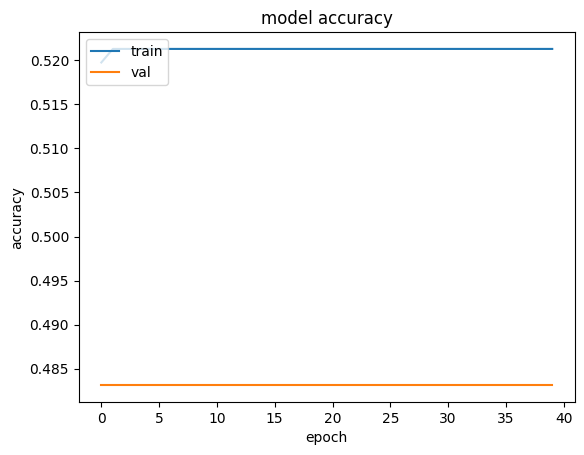

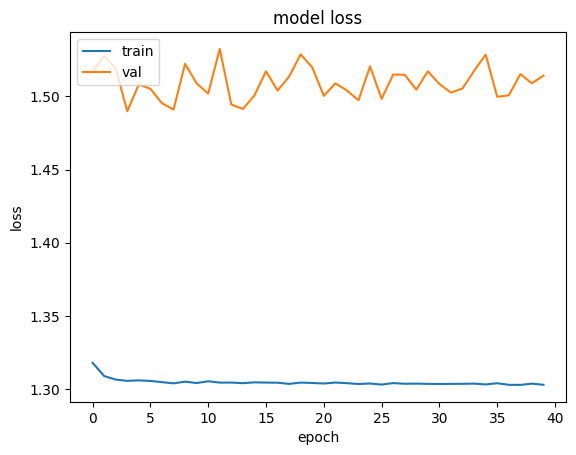

In [ ]:
## MEASURE OUTPUTS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
the_dude = names[names['id'] == 453286]
the_dude

,id,first_name,last_name
69,453286,Max,Scherzer
